In [15]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, jacfwd
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import random
import matplotlib.pyplot as plt
import sys
import time as time
sys.path.insert(0, '../')

from KAN import KAN

# Create interior points
L_range = (-1.0, 1.0)
H_range = (-1.0, 1.0)
nx, ny = 100, 100
x_interior = np.linspace(L_range[0], L_range[1], nx)
y_interior = np.linspace(H_range[0], H_range[1], ny)

# Create boundary points
x_left = np.array(L_range[0]).reshape(-1)
y_left = y_interior
x_right = np.array(L_range[1]).reshape(-1)
y_right = y_interior
x_bottom = x_interior
y_bottom = np.array(H_range[0]).reshape(-1)
x_top = x_interior
y_top = np.array(H_range[1]).reshape(-1)


print(f"Shape of x_left = {x_interior.shape}") 
print(f"Shape of y_left = {y_interior.shape}")
print(f"Shape of x_left = {x_left.shape}")
print(f"Shape of y_left = {y_left.shape}")
print(f"Shape of x_bottom = {x_bottom.shape}")
print(f"Shape of y_bottom = {y_bottom.shape}")


Shape of x_left = (200,)
Shape of y_left = (200,)
Shape of x_left = (1,)
Shape of y_left = (200,)
Shape of x_bottom = (200,)
Shape of y_bottom = (1,)


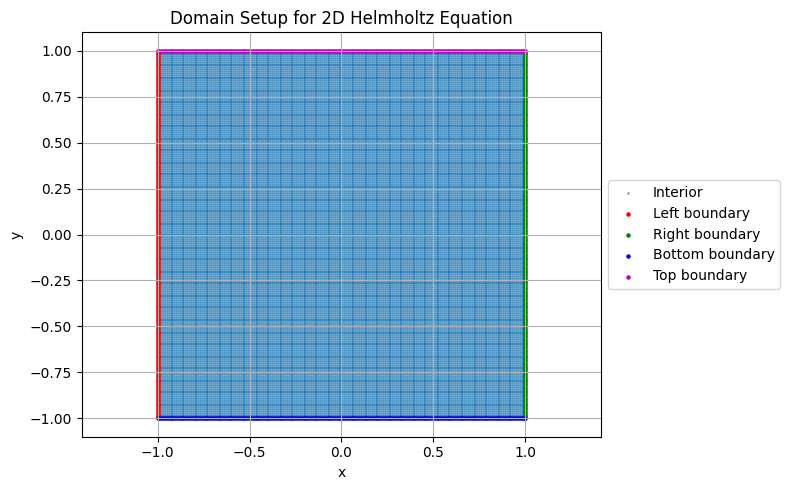

In [16]:
# Function to plot the domain setup
def plot_domain_setup(x_interior, y_interior, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top):
    plt.figure(figsize=(8, 5))
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(x_interior, y_interior)
    
    X_left, Y_left = np.meshgrid(x_left, y_left)
    X_right, Y_right = np.meshgrid(x_right, y_right)
    X_top, Y_top = np.meshgrid(x_top, y_top)
    X_bottom, Y_bottom = np.meshgrid(x_bottom, y_bottom)

    # Plot interior points
    plt.scatter(X, Y, s=1, alpha=0.5, label='Interior')
    
    # Plot boundary points
    plt.scatter(X_left, Y_left, s=5, c='r', label='Left boundary')
    plt.scatter(X_right, Y_right, s=5, c='g', label='Right boundary')
    plt.scatter(X_bottom, Y_bottom, s=5, c='b', label='Bottom boundary')
    plt.scatter(X_top, Y_top, s=5, c='m', label='Top boundary')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Domain Setup for 2D Helmholtz Equation')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Plot the domain setup
plot_domain_setup(x_interior, y_interior, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)



In [17]:
class SF_KAN_Separable:
    def __init__(self, layer_dims, init_lr, k=3, r=5):
        self.input_size = layer_dims[0] # input should always be 1 for separable PINNs # TODO: add check later
        self.out_size = layer_dims[-1]
        self.r = r
        self.layer_dims = [self.input_size] + layer_dims[1:-1] + [self.r * self.out_size]
        self.model_x = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        self.model_y = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        
        key1, key2 = jax.random.split(jax.random.PRNGKey(10))
        self.variables_x = self.model_x.init(key1, jnp.ones([1, 1]))
        self.variables_y = self.model_y.init(key2, jnp.ones([1, 1]))
        
        self.optimizer = optax.adam(learning_rate=init_lr, nesterov=True)
        self.opt_state_x = self.optimizer.init(self.variables_x['params'])
        self.opt_state_y = self.optimizer.init(self.variables_y['params'])

        self.train_losses = []

    def predict(self, x, y):
        variables_x, variables_y = self.variables_x, self.variables_y
        preds, _ = self.forward_pass(variables_x, variables_y, x, y)
        return preds


    @partial(jit, static_argnums=(0,))
    def forward_pass(self, variables_x, variables_y, x, y):
        preds_x, spl_regs_x = self.model_x.apply(variables_x, x[:, None])
        preds_y, spl_regs_y = self.model_y.apply(variables_y, y[:, None])
        
        # print(f"preds_x shape = {preds_x.shape}")
        # print(f"preds_y shape = {preds_y.shape}")

        preds_x = preds_x.reshape(-1, self.out_size, self.r)
        preds_y = preds_y.reshape(-1, self.out_size, self.r)
        # preds = jnp.einsum('ir,jr->ijr', preds_x, preds_y)
        preds = jnp.einsum('ijk,ljk->ilj', preds_x, preds_y)
        # print(f"preds shape = {preds.shape}")

        spl_regs = spl_regs_x + spl_regs_y
        
        return preds, spl_regs

    @partial(jit, static_argnums=(0,))
    def loss(self, params_x, params_y, state_x, state_y, *args):
        variables_x = {'params': params_x, 'state': state_x}
        variables_y = {'params': params_y, 'state': state_y}
        return self.loss_fn(variables_x, variables_y, *args)

    @partial(jit, static_argnums=(0,))
    def train_step(self, params_x, params_y, state_x, state_y, opt_state_x, opt_state_y, *args):
        (loss_value, (physics_loss, boundary_loss)), grads = jax.value_and_grad(self.loss, has_aux=True, argnums=(0,1))(
            params_x, params_y, state_x, state_y, *args
        )
        grads_x, grads_y = grads

        updates_x, opt_state_x = self.optimizer.update(grads_x, opt_state_x)
        updates_y, opt_state_y = self.optimizer.update(grads_y, opt_state_y)

        params_x = optax.apply_updates(params_x, updates_x)
        params_y = optax.apply_updates(params_y, updates_y)

        return params_x, params_y, opt_state_x, opt_state_y, loss_value, physics_loss, boundary_loss

    def train(self, num_epochs, *args):
        params_x, state_x = self.variables_x['params'], self.variables_x['state']
        params_y, state_y = self.variables_y['params'], self.variables_y['state']
        opt_state_x, opt_state_y = self.opt_state_x, self.opt_state_y
        loss_history = []

        pbar = trange(num_epochs, smoothing=0.)
        for epoch in pbar:                
            params_x, params_y, opt_state_x, opt_state_y, loss_value, physics_loss, boundary_loss = self.train_step(
                params_x, params_y, state_x, state_y, opt_state_x, opt_state_y, *args
            )
            loss_history.append(loss_value)

            if epoch % 10 == 0:
                pbar.set_postfix({
                    'Total Loss': f"{loss_value:.4e}",
                    'Physics Loss': f"{physics_loss:.4e}",
                    'Boundary Loss': f"{boundary_loss:.4e}"
                })
        
        self.variables_x = {'params': params_x, 'state': state_x}
        self.variables_y = {'params': params_y, 'state': state_y}
        return loss_history


class Helmholtz_SF_KAN_Separable(SF_KAN_Separable):
    def __init__(self, *args, kappa=1.0, a1=1.0, a2=4.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.kappa = kappa
        self.a1 = a1
        self.a2 = a2

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, variables_x, variables_y, x_interior, y_interior, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top):
        # Compute physics residuals
        residuals = self.compute_residuals(variables_x, variables_y, x_interior, y_interior)
        physics_loss = jnp.mean(jnp.square(residuals))

        # Boundary losses
        preds_left, _ = self.forward_pass(variables_x, variables_y, x_left, y_left)
        preds_right, _ = self.forward_pass(variables_x, variables_y, x_right, y_right)
        preds_bottom, _ = self.forward_pass(variables_x, variables_y, x_bottom, y_bottom)
        preds_top, _ = self.forward_pass(variables_x, variables_y, x_top, y_top)

        left_loss = jnp.mean(jnp.square(preds_left))
        right_loss = jnp.mean(jnp.square(preds_right))
        bottom_loss = jnp.mean(jnp.square(preds_bottom))
        top_loss = jnp.mean(jnp.square(preds_top))

        boundary_loss = left_loss + right_loss + bottom_loss + top_loss

        # Total loss
        total_loss = physics_loss + boundary_loss

        return total_loss, (physics_loss, boundary_loss)

    @partial(jit, static_argnums=(0,))
    def compute_residuals(self, variables_x, variables_y, x_interior, y_interior):
        def model_x_func(x):
            x_feat = self.model_x.apply(variables_x, x.reshape(-1, 1))[0]
            return x_feat.reshape(self.out_size, self.r)

        def model_y_func(y):
            y_feat = self.model_y.apply(variables_y, y.reshape(-1, 1))[0]
            return y_feat.reshape(self.out_size, self.r)

        def model_x_hess(x):
            return jacfwd(jacfwd(model_x_func))(x)

        def model_y_hess(y):
            return jacfwd(jacfwd(model_y_func))(y)

        x_feats = vmap(model_x_func)(x_interior)
        y_feats = vmap(model_y_func)(y_interior)
        x_hess = vmap(model_x_hess)(x_interior)
        y_hess = vmap(model_y_hess)(y_interior)

        u_x, u_y = x_feats[:, 0, :], y_feats[:, 0, :]
        d2u_x_dx2, d2u_y_dy2 = x_hess[:, 0, :], y_hess[:, 0, :]

        u = jnp.einsum('ir,jr->ij', u_x, u_y)
        d2u_dx2 = jnp.einsum('ir,jr->ij', d2u_x_dx2, u_y)
        d2u_dy2 = jnp.einsum('ir,jr->ij', u_x, d2u_y_dy2)

        # Compute the forcing term q(x,y)
        q = (-(self.a1 * jnp.pi)**2 * jnp.sin(self.a1 * jnp.pi * x_interior[:, None]) * jnp.sin(self.a2 * jnp.pi * y_interior[None, :]) +
             jnp.sin(self.a1 * jnp.pi * x_interior[:, None]) * jnp.sin(self.a2 * jnp.pi * y_interior[None, :]) -
             (self.a2 * jnp.pi)**2 * jnp.sin(self.a1 * jnp.pi * x_interior[:, None]) * jnp.sin(self.a2 * jnp.pi * y_interior[None, :]) +
             self.kappa**2 * jnp.sin(self.a1 * jnp.pi * x_interior[:, None]) * jnp.sin(self.a2 * jnp.pi * y_interior[None, :]))

        # Compute the residual of the Helmholtz equation
        residual = d2u_dx2 + d2u_dy2 + self.kappa**2 * u - q

        return residual


In [18]:
# Model parameters
layer_dims = [1, 5, 5, 1]  # Input dim is 1, output dim is 1 (u)
init_lr = 1e-3
k = 3 # KAN spline order
r = 5 # latent dimension of SPIKAN

# Helmholtz equation parameters
kappa = 1.0
a1 = 1.0
a2 = 4.0

model = Helmholtz_SF_KAN_Separable(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k=k,
    kappa=kappa,
    a1=a1,
    a2=a2
)

num_epochs = 20000
loss_history = model.train(
    num_epochs,
    x_interior, y_interior,
    x_left, y_left,
    x_right, y_right,
    x_bottom, y_bottom,
    x_top, y_top
)


100%|██████████| 20000/20000 [01:07<00:00, 298.41it/s, Total Loss=1.0015e-01, Physics Loss=9.4958e-02, Boundary Loss=5.1883e-03]


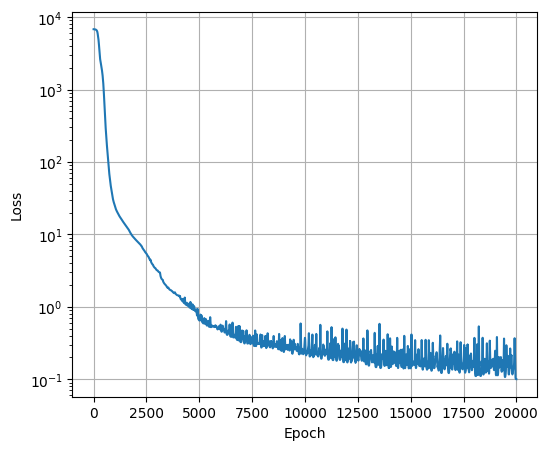

In [19]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(6, 5))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)


In [20]:
# Generate solution
nx_plot, ny_plot = nx, ny

x_plot = np.linspace(-1, 1, nx_plot)
y_plot = np.linspace(-1, 1, ny_plot)
X_mesh, Y_mesh = np.meshgrid(x_plot, y_plot)
u_pred = model.predict(x_plot, y_plot).squeeze().T


# Create dictionary with all field data
output_data = {
    'x': x_plot,
    'y': y_plot,
    'u': u_pred,
    'k':k,
    'a1':a1,
    'a2':a2
}

# Save data
np.save(f'./data/2d_helmholtz_spikan_nx{nx}_ny{ny}_{layer_dims}.npy', output_data)




In [21]:
def count_trainable_params(variables_x, variables_y):
    # Flatten the parameter trees
    flat_params_x, _ = jax.tree_util.tree_flatten(variables_x['params'])
    flat_params_y, _ = jax.tree_util.tree_flatten(variables_y['params'])
    
    # Sum the number of elements in each parameter array for both models
    total_params_x = sum(p.size for p in flat_params_x)
    total_params_y = sum(p.size for p in flat_params_y)
    
    # Total trainable parameters in the entire separable model
    total_params = total_params_x + total_params_y
    return total_params

# Assuming `variables_x` and `variables_y` have been initialized in your model
num_params = count_trainable_params(model.variables_x, model.variables_y)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 910
